In [7]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from util.plots import plot_history
from nets.cnn_net.cnn_net import cnn_net
from glob import glob
import util.image_import as ii
import os
from keras.utils.np_utils import to_categorical
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Trick to configure gpu memory dynamically

In [8]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing

In [9]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train")

def subtract_mean(img):
    return img - mean_image_train

In [10]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size)

Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

### All classes with both types of catfood

In [12]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_all_classes.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [13]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            use_multiprocessing=True,
            workers=4,
            callbacks=callback_list)

Epoch 1/100
58/58 [==============================] - 27s 470ms/step - loss: 2.1657 - acc: 0.1293 - val_loss: 2.0777 - val_acc: 0.1451

Epoch 00001: val_acc improved from -inf to 0.14509, saving model to saved_models/cnn.e01-a0.15.hdf5
Epoch 2/100
58/58 [==============================] - 26s 456ms/step - loss: 2.0771 - acc: 0.1342 - val_loss: 2.0765 - val_acc: 0.1406

Epoch 00002: val_acc did not improve from 0.14509
Epoch 3/100
58/58 [==============================] - 27s 465ms/step - loss: 2.0758 - acc: 0.1399 - val_loss: 2.0716 - val_acc: 0.0714

Epoch 00003: val_acc did not improve from 0.14509
Epoch 4/100
58/58 [==============================] - 28s 491ms/step - loss: 2.0746 - acc: 0.1308 - val_loss: 2.0229 - val_acc: 0.1942

Epoch 00004: val_acc improved from 0.14509 to 0.19420, saving model to saved_models/cnn.e04-a0.19.hdf5
Epoch 5/100
58/58 [==============================] - 28s 480ms/step - loss: 2.0165 - acc: 0.1839 - val_loss: 1.8416 - val_acc: 0.2812

Epoch 00005: val_acc i

58/58 [==============================] - 29s 504ms/step - loss: 0.6411 - acc: 0.7406 - val_loss: 0.4021 - val_acc: 0.8728

Epoch 00081: val_acc did not improve from 0.90625
Epoch 82/100
58/58 [==============================] - 29s 503ms/step - loss: 0.6154 - acc: 0.7539 - val_loss: 0.3494 - val_acc: 0.9018

Epoch 00082: val_acc did not improve from 0.90625
Epoch 83/100
58/58 [==============================] - 28s 476ms/step - loss: 0.5937 - acc: 0.7501 - val_loss: 0.2971 - val_acc: 0.9107

Epoch 00083: val_acc improved from 0.90625 to 0.91071, saving model to saved_models/cnn.e83-a0.91.hdf5
Epoch 84/100
58/58 [==============================] - 28s 487ms/step - loss: 0.6160 - acc: 0.7489 - val_loss: 0.3346 - val_acc: 0.8594

Epoch 00084: val_acc did not improve from 0.91071
Epoch 85/100
58/58 [==============================] - 30s 511ms/step - loss: 0.5925 - acc: 0.7489 - val_loss: 0.3412 - val_acc: 0.8884

Epoch 00085: val_acc did not improve from 0.91071
Epoch 86/100
58/58 [==========

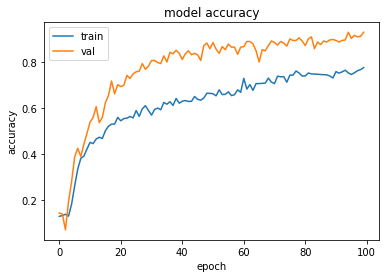

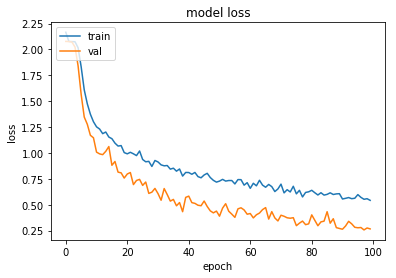

In [15]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_all_classes')

### Not trained on catfood_beef
* Catfood beef and catfood salmon is in some picture identical so it is not possible to differentiate between the two classes, thus a model is trained without catfood beef

In [16]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train", ['catfood_beef'])

def subtract_mean(img):
    return img - mean_image_train

In [17]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

Found 1641 images belonging to 7 classes.
Found 413 images belonging to 7 classes.


In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(7))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [19]:
# Checkpoint to save best model
file_path = 'saved_models/cnn_without_catbeef.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [20]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1641 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=413 // batch_size,
            use_multiprocessing=True,
            workers=4,
            callbacks=callback_list)

Epoch 1/100
51/51 [==============================] - 24s 477ms/step - loss: 2.0206 - acc: 0.1388 - val_loss: 1.9391 - val_acc: 0.1615

Epoch 00001: val_acc improved from -inf to 0.16146, saving model to saved_models/cnn_without_catbeef.e01-a0.16.hdf5
Epoch 2/100
51/51 [==============================] - 24s 473ms/step - loss: 1.8888 - acc: 0.1814 - val_loss: 1.6760 - val_acc: 0.2839

Epoch 00002: val_acc improved from 0.16146 to 0.28385, saving model to saved_models/cnn_without_catbeef.e02-a0.28.hdf5
Epoch 3/100
51/51 [==============================] - 28s 556ms/step - loss: 1.6413 - acc: 0.3313 - val_loss: 1.2845 - val_acc: 0.4609

Epoch 00003: val_acc improved from 0.28385 to 0.46094, saving model to saved_models/cnn_without_catbeef.e03-a0.46.hdf5
Epoch 4/100
51/51 [==============================] - 27s 526ms/step - loss: 1.3756 - acc: 0.4493 - val_loss: 1.0761 - val_acc: 0.5833

Epoch 00004: val_acc improved from 0.46094 to 0.58333, saving model to saved_models/cnn_without_catbeef.e0

51/51 [==============================] - 26s 501ms/step - loss: 0.1894 - acc: 0.9298 - val_loss: 0.1385 - val_acc: 0.9766

Epoch 00082: val_acc did not improve from 0.98177
Epoch 83/100
51/51 [==============================] - 25s 489ms/step - loss: 0.2006 - acc: 0.9258 - val_loss: 0.1679 - val_acc: 0.9688

Epoch 00083: val_acc did not improve from 0.98177
Epoch 84/100
51/51 [==============================] - 25s 496ms/step - loss: 0.1769 - acc: 0.9344 - val_loss: 0.1618 - val_acc: 0.9766

Epoch 00084: val_acc did not improve from 0.98177
Epoch 85/100
51/51 [==============================] - 25s 497ms/step - loss: 0.1617 - acc: 0.9418 - val_loss: 0.2427 - val_acc: 0.9688

Epoch 00085: val_acc did not improve from 0.98177
Epoch 86/100
51/51 [==============================] - 26s 515ms/step - loss: 0.1767 - acc: 0.9308 - val_loss: 0.0828 - val_acc: 0.9870

Epoch 00086: val_acc improved from 0.98177 to 0.98698, saving model to saved_models/cnn_without_catbeef.e86-a0.99.hdf5
Epoch 87/100
5

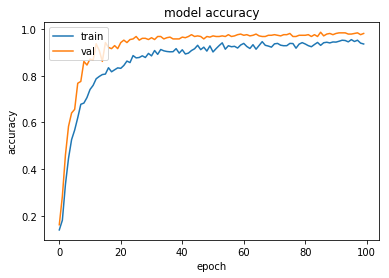

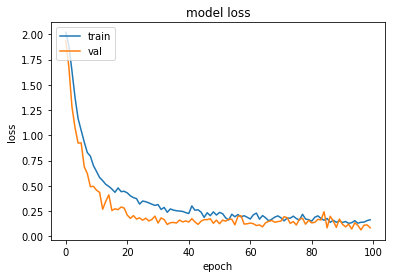

In [21]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_without_catbeef')

The above training on all classes and training without catfood beef is summurized below:

|Summarize             | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
|:--------------------:|:-----:|:-------------:|:-----------------:|:---------------:|:-------------------:|
| All Classes          |   95  |     0.5627    |      0.7543       |      0.2822     |        0.9308       |
| Without catfood beef |   86  |     0.1767    |      0.9308       |      0.0828     |        0.9870       |

The results is the best achieved validation accuracy with the respectivly training accuracy. 

From the results it can be conluded that without the catfood beef the model is performing better. 

Forskellen mellem accuracy stemmer overens at de billeder af dåserne fra begge kattemad ligner hinanden er væk.